### Imports

In [1]:
%matplotlib widget
import os
import sys
import time
sys.path.append(os.path.abspath('..'))

from linetimer import CodeTimer
import matplotlib.pyplot as plt
import nibabel
from nibabel import processing, nifti1, affines
import numpy as np
from skimage.metrics import mean_squared_error, normalized_root_mse

import Resample

### GPU Initialization

In [2]:
GPUBackend='OpenCL'
gpu_name = 'gfx1030'

if GPUBackend=='OpenCL':
    Resample.InitOpenCL(gpu_name)
elif GPUBackend=='CUDA':
    Resample.InitCUDA(gpu_name)
else:
    Resample.InitMetal(gpu_name)

gfx1030
Selecting device:  gfx1030


c:\Users\acoreas\miniconda3\envs\bbl_dev\lib\site-packages\pyopencl\__init__.py:270: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


### Load Input Data

In [3]:
fname = 'D:/acoreas/BabelBrain_Test_Data/SDR_0p55/T1W.nii.gz'
base_name,_ = os.path.splitext(os.path.splitext(fname)[0])
nifti=nibabel.load(fname)
data=np.ascontiguousarray(nifti.get_fdata().astype(np.uint8))

### Determine Output Data Resolution

In [4]:
spatial_steps = {
    'low_res': 0.919, # 6 PPW, 200 kHz
    'medium_res': 0.163, # 9 PPW, 750 kHz
    'high_res': 0.092, # 12 PPW, 1000 kHz
}

spatial_step = spatial_steps['low_res']

# Calculate new affine
T1W_affine_upscaled = affines.rescale_affine(nifti.affine.copy(),nifti.shape,spatial_step,(int(nifti.shape[0]//spatial_step)+1,int(nifti.shape[1]//spatial_step)+1,int(nifti.shape[2]//spatial_step)+1))

# output dimensions
output_data = np.zeros((int(data.shape[0]//spatial_step)+1,int(data.shape[1]//spatial_step)+1,int(data.shape[2]//spatial_step)+1),dtype=np.uint8)
output_nifti = nifti1.Nifti1Image(output_data,T1W_affine_upscaled)

### Run Resample Step

In [5]:
with CodeTimer("GPU Resample", unit="s"):
    resampled_nifti_gpu = Resample.ResampleFromTo(nifti,output_nifti,mode='constant',order=0,cval=data.min(),GPUBackend=GPUBackend)
    resampled_data_gpu = np.ascontiguousarray(resampled_nifti_gpu.get_fdata().astype(np.uint8))

with CodeTimer("CPU Resample", unit="s"):
    # Run resample step
    resampled_fname = base_name + f"_{spatial_step}.nii.gz"
    if os.path.exists(resampled_fname):
        resampled_data_cpu = np.ascontiguousarray(nibabel.load(resampled_fname).get_fdata().astype(np.uint8))
    else:
        resampled_nifti = processing.resample_from_to(nifti,output_nifti,mode='constant',order=0,cval=data.min()) # Truth method
        nibabel.save(resampled_nifti,resampled_fname)
        resampled_data_cpu=np.ascontiguousarray(resampled_nifti.get_fdata().astype(np.uint8))

if resampled_data_gpu.size != resampled_data_cpu.size:
    print(f"Array sizes don't match: {resampled_data_gpu.size} vs {resampled_data_cpu.size}")
if resampled_data_gpu.size == 0:
    print("Arrays are empty")

Starting Resample
Total points: 15957405
Working on slices 0 to 205 out of 205
Code block 'GPU Resample' took: 0.60224 s
Code block 'CPU Resample' took: 0.38927 s


### Plot Data

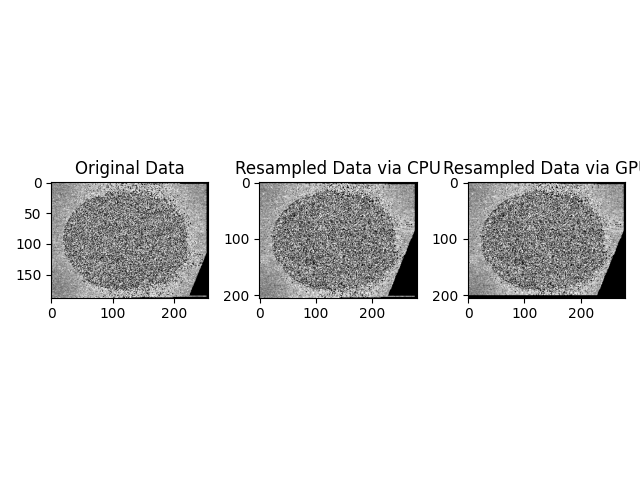

In [6]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(data[:,:,data.shape[2]//2], cmap='gray')
plt.title('Original Data')
plt.subplot(1,3,2)
plt.imshow(resampled_data_cpu[:,:,resampled_data_cpu.shape[2]//2], cmap='gray')
plt.title('Resampled Data via CPU')
plt.subplot(1,3,3)
plt.imshow(resampled_data_gpu[:,:,resampled_data_gpu.shape[2]//2], cmap='gray')
plt.title('Resampled Data via GPU')
plt.tight_layout()



### Check Output Data Matches Truth Data

In [7]:
data_match = np.all(resampled_data_gpu==resampled_data_cpu)
print(f"Data matches? {data_match}")

if not data_match:
    matches = abs(resampled_data_gpu - resampled_data_cpu) < 1e-6
    matches_count = len(matches[matches==True])

    dice_coeff = 2 * matches_count / (resampled_data_gpu.size + resampled_data_cpu.size)

    print(f"Dice Coefficient: {dice_coeff}")

    mse = mean_squared_error(resampled_data_cpu,resampled_data_gpu)
    print(f"Mean square error: {mse}")

    nrmse = normalized_root_mse(resampled_data_cpu,resampled_data_gpu)
    print(f"Normalized root mean square error: {nrmse}")

Data matches? False
Dice Coefficient: 0.9801402546341338
Mean square error: 559.5749541357131
Normalized root mean square error: 0.16657884837823017


### Plot Differences Between Output and Truth

Difference Histogram
0.00 to 25.50: 15654048
25.50 to 51.00: 30412
51.00 to 76.50: 62288
76.50 to 102.00: 86763
102.00 to 127.50: 75693
127.50 to 153.00: 28023
153.00 to 178.50: 5661
178.50 to 204.00: 2930
204.00 to 229.50: 5535
229.50 to 255.00: 6052


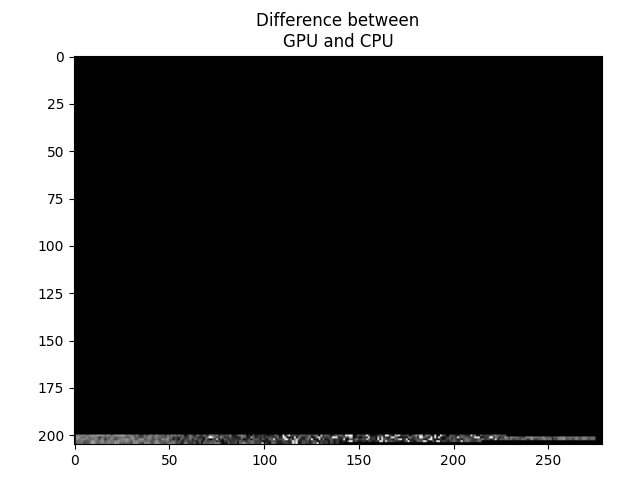

In [8]:
diffs = abs(resampled_data_gpu - resampled_data_cpu)

plt.figure()
plt.imshow(diffs[:,:,diffs.shape[2]//2], cmap='gray')
plt.title('Difference between\nGPU and CPU')
plt.tight_layout()

hist,bins = np.histogram(diffs)
print(f"Difference Histogram")
for bin in range(len(bins)-1):
    print(f"{bins[bin]:.2f} to {bins[bin+1]:.2f}: {hist[bin]}")